In [1]:
import torch
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

dataset = TUDataset(root='data/TUDataset', name='Cuneiform')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cuneiform(267):
Number of graphs: 267
Number of features: 3
Number of classes: 30


In [2]:
torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:210]
test_dataset = dataset[210:]

In [3]:
from torch_geometric.loader import DataLoader

NUM_GRAPHS_PER_BATCH = 124
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = SAGEConv(dataset.num_node_features, 2 * hidden_channels)
        self.conv2 = SAGEConv(2 * hidden_channels, 4 *  hidden_channels)
        self.conv3 = SAGEConv(4 * hidden_channels, 2 * hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

GCN(
  (conv1): SAGEConv(3, 128)
  (conv2): SAGEConv(128, 256)
  (conv3): SAGEConv(256, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=30, bias=True)
)
Number of parameters:  142558
Epoch: 001, Loss: 3.4043, Train Acc: 0.1143, Test Acc: 0.0351
Epoch: 002, Loss: 3.3883, Train Acc: 0.0714, Test Acc: 0.0526
Epoch: 003, Loss: 3.3589, Train Acc: 0.1381, Test Acc: 0.1228
Epoch: 004, Loss: 3.1504, Train Acc: 0.1095, Test Acc: 0.0877
Epoch: 005, Loss: 3.0325, Train Acc: 0.1381, Test Acc: 0.1053
Epoch: 006, Loss: 2.8349, Train Acc: 0.2048, Test Acc: 0.1754
Epoch: 007, Loss: 2.6988, Train Acc: 0.1714, Test Acc: 0.1579
Epoch: 008, Loss: 2.4075, Train Acc: 0.2095, Test Acc: 0.1754
Epoch: 009, Loss: 2.1107, Train Acc: 0.2619, Test Acc: 0.1404
Epoch: 010, Loss: 2.1807, Train Acc: 0.3381, Test Acc: 0.1754
Epoch: 011, Loss: 2.0513, Train Acc: 0.3524, Test Acc: 0.2807
Epoch: 012, Loss: 1.9418, Train Acc: 0.3714, Test Acc: 0.2456
Epoch: 0

Epoch: 130, Loss: 0.9436, Train Acc: 0.7714, Test Acc: 0.5789
Epoch: 131, Loss: 0.7957, Train Acc: 0.7476, Test Acc: 0.6316
Epoch: 132, Loss: 0.7019, Train Acc: 0.6952, Test Acc: 0.6667
Epoch: 133, Loss: 0.8343, Train Acc: 0.7476, Test Acc: 0.6491
Epoch: 134, Loss: 0.7789, Train Acc: 0.7238, Test Acc: 0.5789
Epoch: 135, Loss: 0.7787, Train Acc: 0.7952, Test Acc: 0.5965
Epoch: 136, Loss: 0.6865, Train Acc: 0.7762, Test Acc: 0.6316
Epoch: 137, Loss: 0.6342, Train Acc: 0.7190, Test Acc: 0.5614
Epoch: 138, Loss: 0.8499, Train Acc: 0.7286, Test Acc: 0.5263
Epoch: 139, Loss: 0.7734, Train Acc: 0.7952, Test Acc: 0.5965
Epoch: 140, Loss: 0.6704, Train Acc: 0.7286, Test Acc: 0.5439
Epoch: 141, Loss: 0.6917, Train Acc: 0.7476, Test Acc: 0.6316
Epoch: 142, Loss: 0.6243, Train Acc: 0.7714, Test Acc: 0.7018
Epoch: 143, Loss: 0.7101, Train Acc: 0.7810, Test Acc: 0.7895


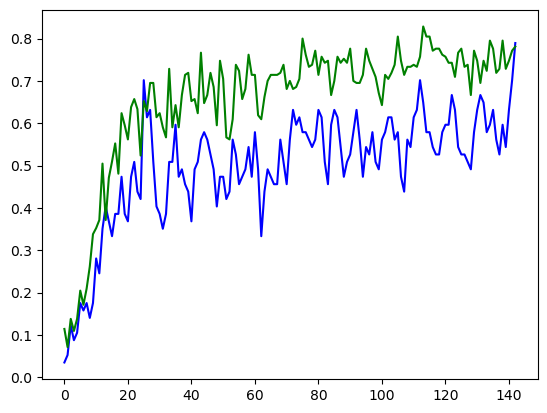

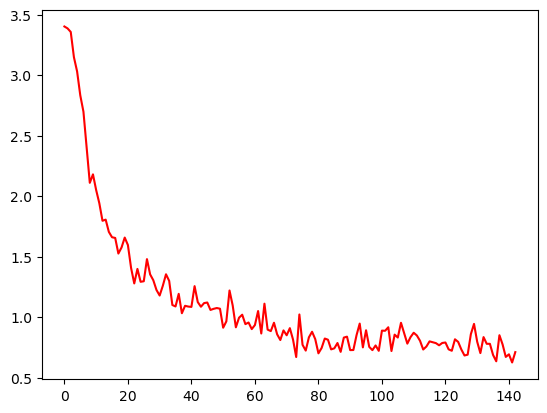

In [5]:
model = GCN(hidden_channels=NUM_HIDDEN_CHANNELS)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

loss_values = []
train_acc_values = []
acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
        
    loss_values.append(loss)
    acc_values.append(test_acc)
    train_acc_values.append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    if(test_acc > 0.75): break

plt.plot(acc_values, 'b', train_acc_values, 'g')
plt.savefig('cuneiform_acc.png')
plt.show()

losses = [loss_values[i].item() for i in range(0, len(loss_values))]
plt.plot(losses, 'r')
plt.savefig('cuneiform_loss.png')
plt.show()